In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls

drive  sample_data


In [ ]:
!git clone https://github.com/cplusx/QATM.git

Cloning into 'QATM'...
remote: Enumerating objects: 468, done.
remote: Total 468 (delta 0), reused 0 (delta 0), pack-reused 468
Receiving objects: 100% (468/468), 9.19 MiB | 37.64 MiB/s, done.
Resolving deltas: 100% (22/22), done.


In [ ]:
!7z x drive/MyDrive/Dataset.7z -o.


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 5359681573 bytes (5112 MiB)

Extracting archive: drive/MyDrive/Dataset.7z
--
Path = drive/MyDrive/Dataset.7z
Type = 7z
Physical Size = 5359681573
Headers Size = 279463
Method = LZMA2:24
Solid = +
Blocks = 3

  0%      0% 1        0% 11 - Dataset/Sample0004_Image.png                                        0% 12 - Dataset/Sample0004_Template.png                                           0% 23 - Dataset/Sample0008_Image.png                                        0% 36 -

# Using QATM for template matching

In [ ]:
from __future__ import print_function, division

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os, sys

In [ ]:
import keras
import tensorflow as tf
from keras.layers import Input, Lambda, Concatenate
from keras import Model
import keras.backend as K
from keras.applications.vgg16 import preprocess_input
import progressbar

In [ ]:
print(keras.__version__, tf.__version__)

2.9.0 2.9.2


In [ ]:
from QATM.models import QATM, MyNormLayer
from QATM.utils import compute_score, all_sample_iou, plot_success_curve

In [ ]:
file_dir = 'QATM/data'
gt = sorted([ os.path.join(file_dir, i) for i in os.listdir(file_dir)  if '.txt' in i ])
img_path = sorted([ os.path.join(file_dir, i) for i in os.listdir(file_dir) if '.jpg' in i ] )
def read_gt( file_path ):
    with open( file_path ) as IN:
        x, y, w, h = [ eval(i) for i in IN.readline().strip().split(',')]
    return x, y, w, h

In [ ]:
sss=np.array(1)

In [ ]:
def create_model( featex, alpha = 1. ):
    T = Input( (None, None, 3), name='template_input' )
    I = Input( (None, None, 3), name='image_input' )
    T_feat = featex(T)
    I_feat = featex(I)
    I_feat, T_feat = MyNormLayer( name='norm_layer' )( [I_feat, T_feat] )
    dist = Lambda( lambda x: tf.einsum( "xabc,xdec->xabde", K.l2_normalize(x[0], axis=-1), K.l2_normalize(x[1], axis=-1) ) , name="cosine_dist")([ I_feat, T_feat ])
    conf_map = QATM(alpha, name='qatm')( dist )
    return Model( [T, I], [conf_map], name='QATM_model' )
    
def model_eval( featex, alpha=1., backup=None ):
    '''
    Have a backup featex in case image is too big.
    '''
    model = create_model( featex , alpha=alpha)
    if backup is not None:
        model_bkup = create_model( backup , alpha=alpha)
    else:
        model_bkup = model
    gt_list, gray_list, score_list = [], [], []

    num_samples = len(img_path) // 2
    bar = progressbar.ProgressBar(max_value=num_samples)
    for idx in range(num_samples):
        bar.update(idx + 1)
        # load image and ground truth
        template_raw = cv2.imread( img_path[2*idx] )[...,::-1]
        template_bbox = read_gt( gt[2*idx] )
        x, y, w, h = [int(round(t)) for t in template_bbox]
        template = template_raw[y:y+h, x:x+w]
        image = cv2.imread( img_path[2*idx+1] )[...,::-1]
        image_gt = read_gt( gt[2*idx+1] )
        x_gt, y_gt, w_gt, h_gt = [int(round(t)) for t in image_gt]
        
        # process images
        template_ = np.expand_dims(preprocess_input( template ), axis=0)
        image_ = np.expand_dims(preprocess_input( image ) , axis=0)
        if w*h <= 4000:
            val = model.predict( [template_, image_] )
            # plt.figure()
            # plt.imshow(np.squeeze(np.log(val)))
            # plt.show()
        else:
            # used when image is too big
            val = model_bkup.predict( [template_, image_] )
        
        # compute geometry mean on score map
        val = np.log( val )
        gray = val[0,:,:,0]
        gray = cv2.resize( gray, (image.shape[1], image.shape[0]) )
        score = compute_score( gray, w_gt, h_gt )
        print('wwwwwwwwwwwwww', score.shape)
        
        score[score>-1e-7] = -np.inf
        plt.figure()
        plt.imshow(score)
        plt.show()
        
        gt_list.append( image_gt )
        gray_list.append( gray )
        score_list.append( score )
    return score_list, gt_list, gray_list

In [ ]:
vgg19 = keras.applications.vgg19.VGG19( include_top = False, weights = 'imagenet' )

In [ ]:
# resize conv3_4 to conv1_2
input_ = vgg19.input
conv1_2 = vgg19.get_layer('block1_conv2').output
conv3_4 = vgg19.get_layer('block3_conv4').output
conv3_4 = Lambda( lambda x: tf.compat.v1.image.resize_bilinear( x[0], size=(tf.shape(x[1])[1], tf.shape(x[1])[2]), align_corners=True), name='resized_image' )( [conv3_4, conv1_2] )
concat = Concatenate()( [conv1_2, conv3_4] )
featex = Model( [input_], [concat], name='featex' )
# resize conv1_2 to conv3_4, used when image size is too big
input_ = vgg19.input
conv1_2 = vgg19.get_layer('block1_conv2').output
conv3_4 = vgg19.get_layer('block3_conv4').output
conv1_2 = Lambda( lambda x: tf.compat.v1.image.resize_bilinear( x[1], size=(tf.shape(x[0])[1], tf.shape(x[0])[2]), align_corners=True), name='resized_image' )( [conv3_4, conv1_2] )
concat = Concatenate()( [conv1_2, conv3_4] )
featex2 = Model( [input_], [concat], name='featex2' )

N/A% (0 of 105) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

1/1 [==============================] - 1s 696ms/step
wwwwwwwwwwwwww (270, 480)


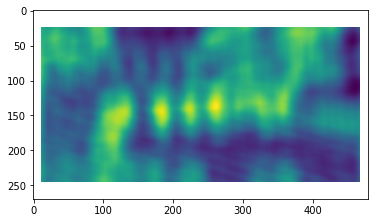

  1% (2 of 105) |                        | Elapsed Time: 0:00:01 ETA:   0:00:55

1/1 [==============================] - 0s 307ms/step
wwwwwwwwwwwwww (270, 480)


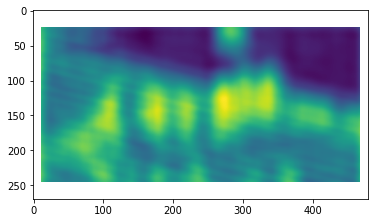

  2% (3 of 105) |                        | Elapsed Time: 0:00:01 ETA:   0:00:59

1/1 [==============================] - 0s 308ms/step
wwwwwwwwwwwwww (270, 480)


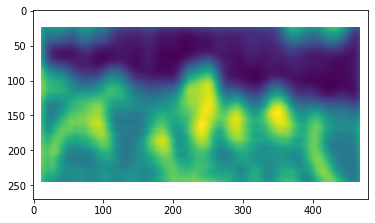

  3% (4 of 105) |                        | Elapsed Time: 0:00:02 ETA:   0:01:01

1/1 [==============================] - 1s 654ms/step
wwwwwwwwwwwwww (360, 480)


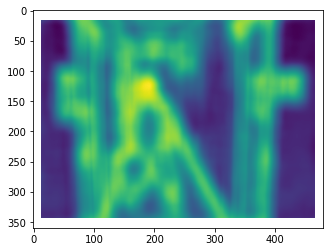

  4% (5 of 105) |#                       | Elapsed Time: 0:00:03 ETA:   0:01:20

1/1 [==============================] - 0s 370ms/step
wwwwwwwwwwwwww (360, 480)


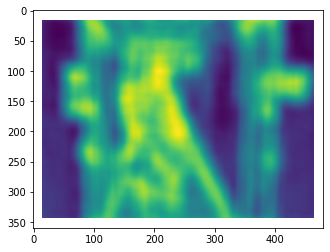

  5% (6 of 105) |#                       | Elapsed Time: 0:00:04 ETA:   0:01:23

1/1 [==============================] - 0s 383ms/step
wwwwwwwwwwwwww (360, 480)


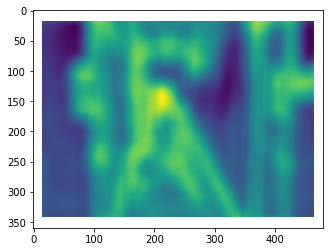

  6% (7 of 105) |#                       | Elapsed Time: 0:00:05 ETA:   0:01:27

1/1 [==============================] - 0s 336ms/step


KeyboardInterrupt: ignored

In [ ]:
for k in [20]:
    score_list, gt_list, gray_list = model_eval( featex, alpha=k, backup=featex2)
    iou_score = all_sample_iou( score_list, gt_list )
    plot_success_curve( iou_score, title='alpha={} '.format(k) )

In [ ]:
print(sss)

1


In [ ]:
import gc

In [ ]:
gc.collect()

10752